# Creating a chord progression with a genetic algorithm

This work is the result of an experiment done some months ago. I used a simple genetic algorithm to find a solution to a classic exercise of harmony: given a certain voice (normally the bass) create the other three voices to make a chord progression. I know that the aproach to solve a progression with a genetic algorithm may not be the best I just wanted to play with this algorithms making somthing fun, the code isn't perfect and the algorithm can be improved adding more options in the chord selection, but for simplicity I didn't use seventh chords.

## Working with music

The first part of this challenge is to find a way to easily represent the notes in the melody, luckily for us many years ago MIDI was created, so I used the numbers in MIDI to match every single note being, for example, 60 the central C. And at the beginning of the sequence of notes I set the key signature with the number of sharps or flats.

So an example like this:

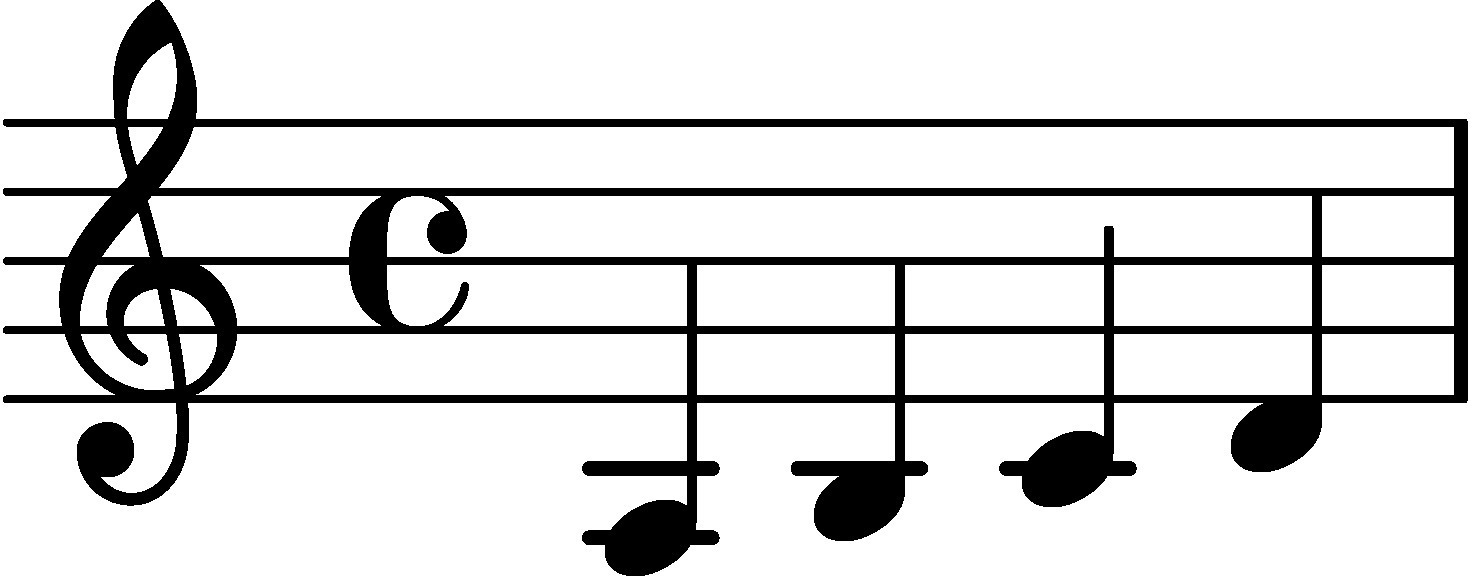

In [1]:
from IPython import display

display.Image('img/simple.jpg', width=400)

Will be rempresented as: **0# 57 59 60 62**

### Lilypond

Going from music notation to this MIDI number representation with just one voice is quite easy (although I might work a hack for that also), but once I generate all the notes that form the chords the process ends up being a pain in the ass. Therefore, at the end I take the output and pass it through a little script that transform the numbers to [Lilypond](http://www.lilypond.com), generate a .ly file and an .jpg of the sheet.

## The genetic algorithm

A genetic algorithm works pretty much like a species evolution in real life. You take a group of individuals, called population, in this population there are a few individuals that have the best attributes, those are the ones that will survive and carry on the genes to the next generation. This process continues generation over generation until there is an individual with the perfect attributes, or at least with the best so far. You can read more in [Wikipedia](https://en.wikipedia.org/wiki/Genetic_algorithm).

The process can be structured in this steps:
- Initialization
- Selection
- Crossover
- Mutation
- Termination

Let's tackle them one by one. But first let me explain the framework that I used.

### Working enviroment

I used a library called [DEAP](https://github.com/deap), Distributed Evolutionary Algorithms in Python, it is a novel evolutionary computation framework for rapid prototyping and testing of ideas. It has all the basic tools to work with genetic algorithms you only have to create the functions to create, select, mate and mutate the individuals.

In [2]:
import random
import math
import numpy
from string import Template

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

from lily_template import TEMPLATE

The file lily\_template has the template to create the lilypond file and to give it format I used the string.Template class.
Then I set some global variables that I'm going to use:

OPTIONS\_\* are the different roles that a note can have in a chord: The first note in the scale of the tonality can be the first note in the tonic chord, the third degree in the 6° chord or the fifth degree in the subdominant. So I represented this options as differences between the fundamental note of the possible chords and the note degree in the scale.
This diferences change a little bit in a minor tonality.

MOD\_\* are just the grades of the chords in a major and a minor tonality.

In [3]:
# Global Variables
OPTIONS_M = ((0,-3,5), (0,-3,5), (0,-4,5), (0,-3,6), (0,-3,5), (0,-4,5), (0,-4,5))
OPTIONS_m = ((0,-4,5), (0,-4,5), (0,-3,5), (0,-3,5), (0,-4,5), (0,-3,6), (0,5))
MOD_M = ('M','m','m','M','M','m','d')
MOD_m = ('m','d','M','m','M','M','M')

### Initialization

In the initialization part, you have to create the initial population with all the individuals. In this example an individual will be a chord progression, with all the chords beeing of four notes each. I represented each individual as a list of chords, and each chord a list of notes, for example:

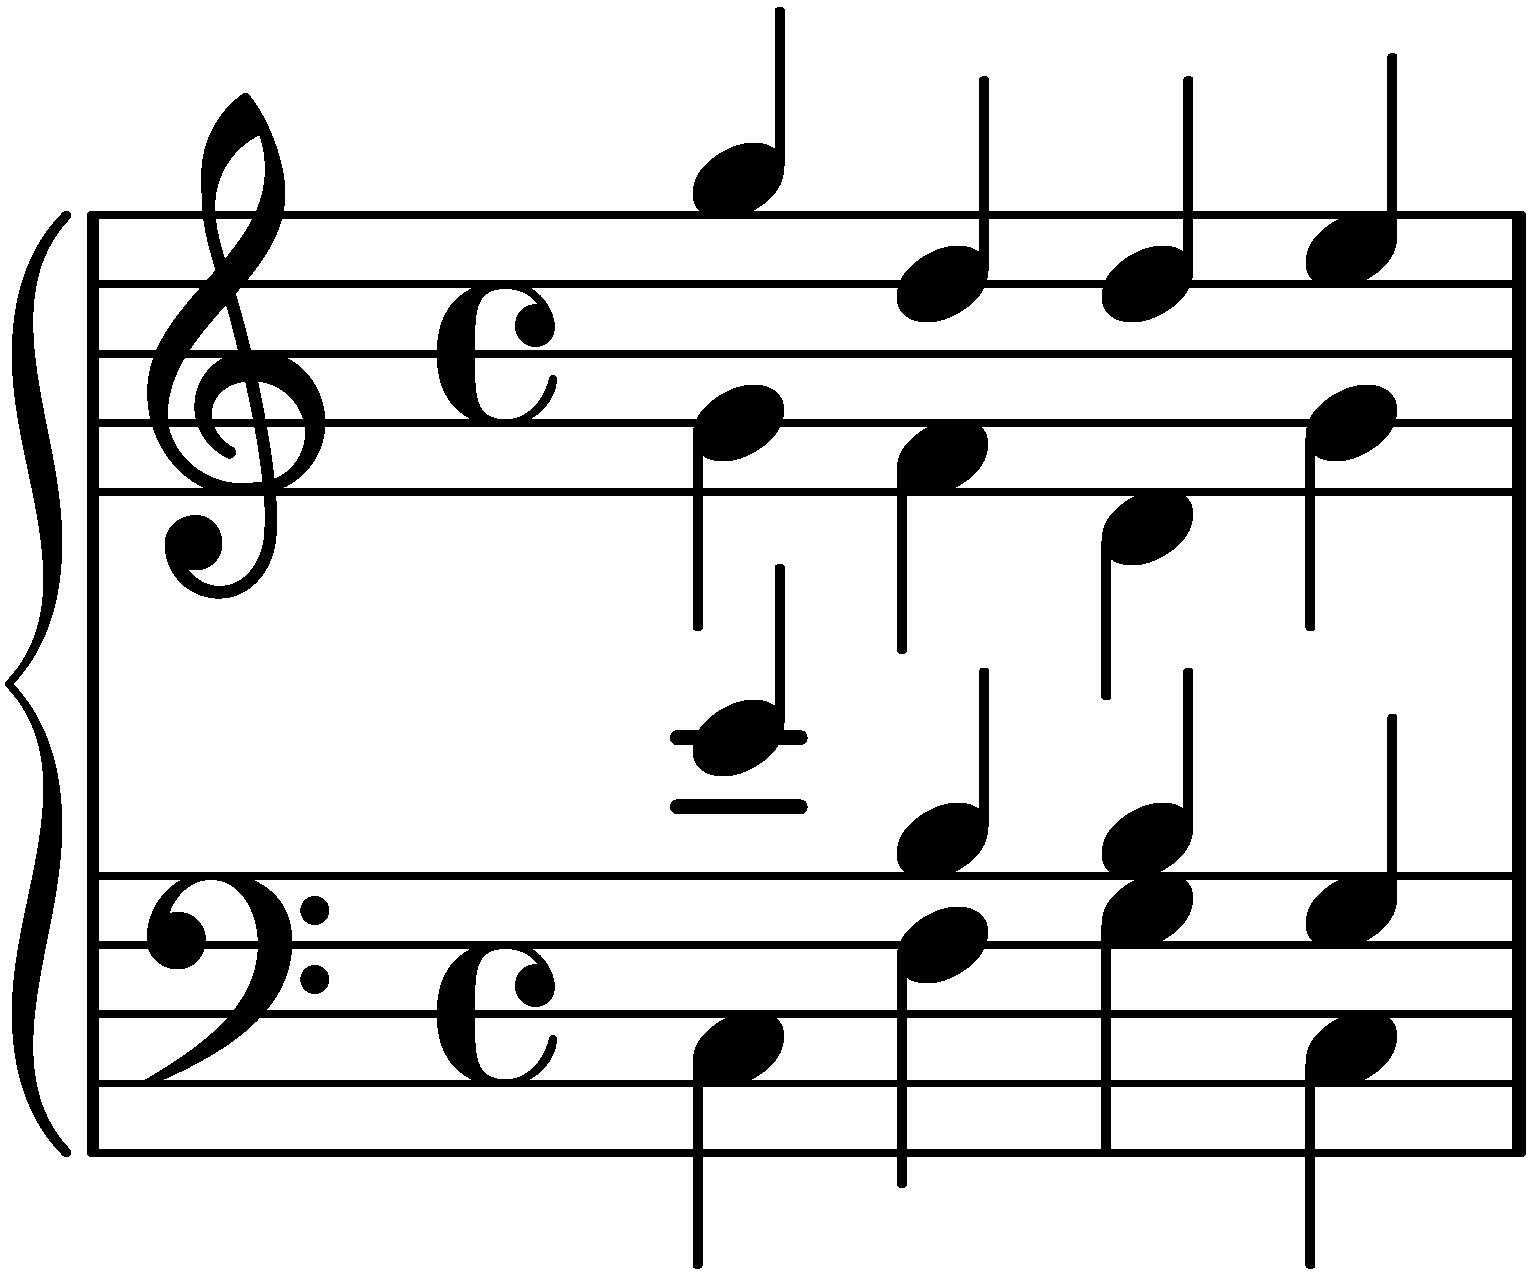

In [4]:
display.Image('img/ex_prog.jpg', width=400)

This individual would be represented as
[[48, 64, 67, 79], [53, 59, 65, 74], [55, 59, 62, 74], [48, 55, 67, 76]] 

To do anything I need the tonality of the exercise, so I defined a function to find it given the bass voice and the key signature, it just looks at the key signature and it looks if the voice has any sight of being a minor key:

In [5]:
def setTon(line):
    """Return the tonality of the exercise and the bass notes of it"""
    ton = line[:2]
    notes = list(map(int, line[3:].split(' ')))
    if ton[1] == '#':
        ton = (int(ton[0])*7)%12
    else:
        ton = (int(ton[0])*5)%12
    for note in notes:
        if (ton+6)%12 == note%12:
            ton = str((ton-3)%12)+'m'
            break
    else:
        if ton-3 == notes[-1]%12:
            ton = str((ton-3)%12)+'m'
        else:
            ton = str(ton)+'M'
    return ton, notes

The function returns a tuple with the tonality represented as a number from 0 to 11 (C to B) and a 'M' if the tonality is major or 'm' if it's minor.

Then I wrote a function to create a single chord given the name of the chord and the fundamental note. The interesting part of this is that a chord of four notes can have multiple permutations, different set of notes and it can have a [close or open harmony](https://en.wikipedia.org/wiki/Close_and_open_harmony).

For example all these chords are D major and have the same bass:

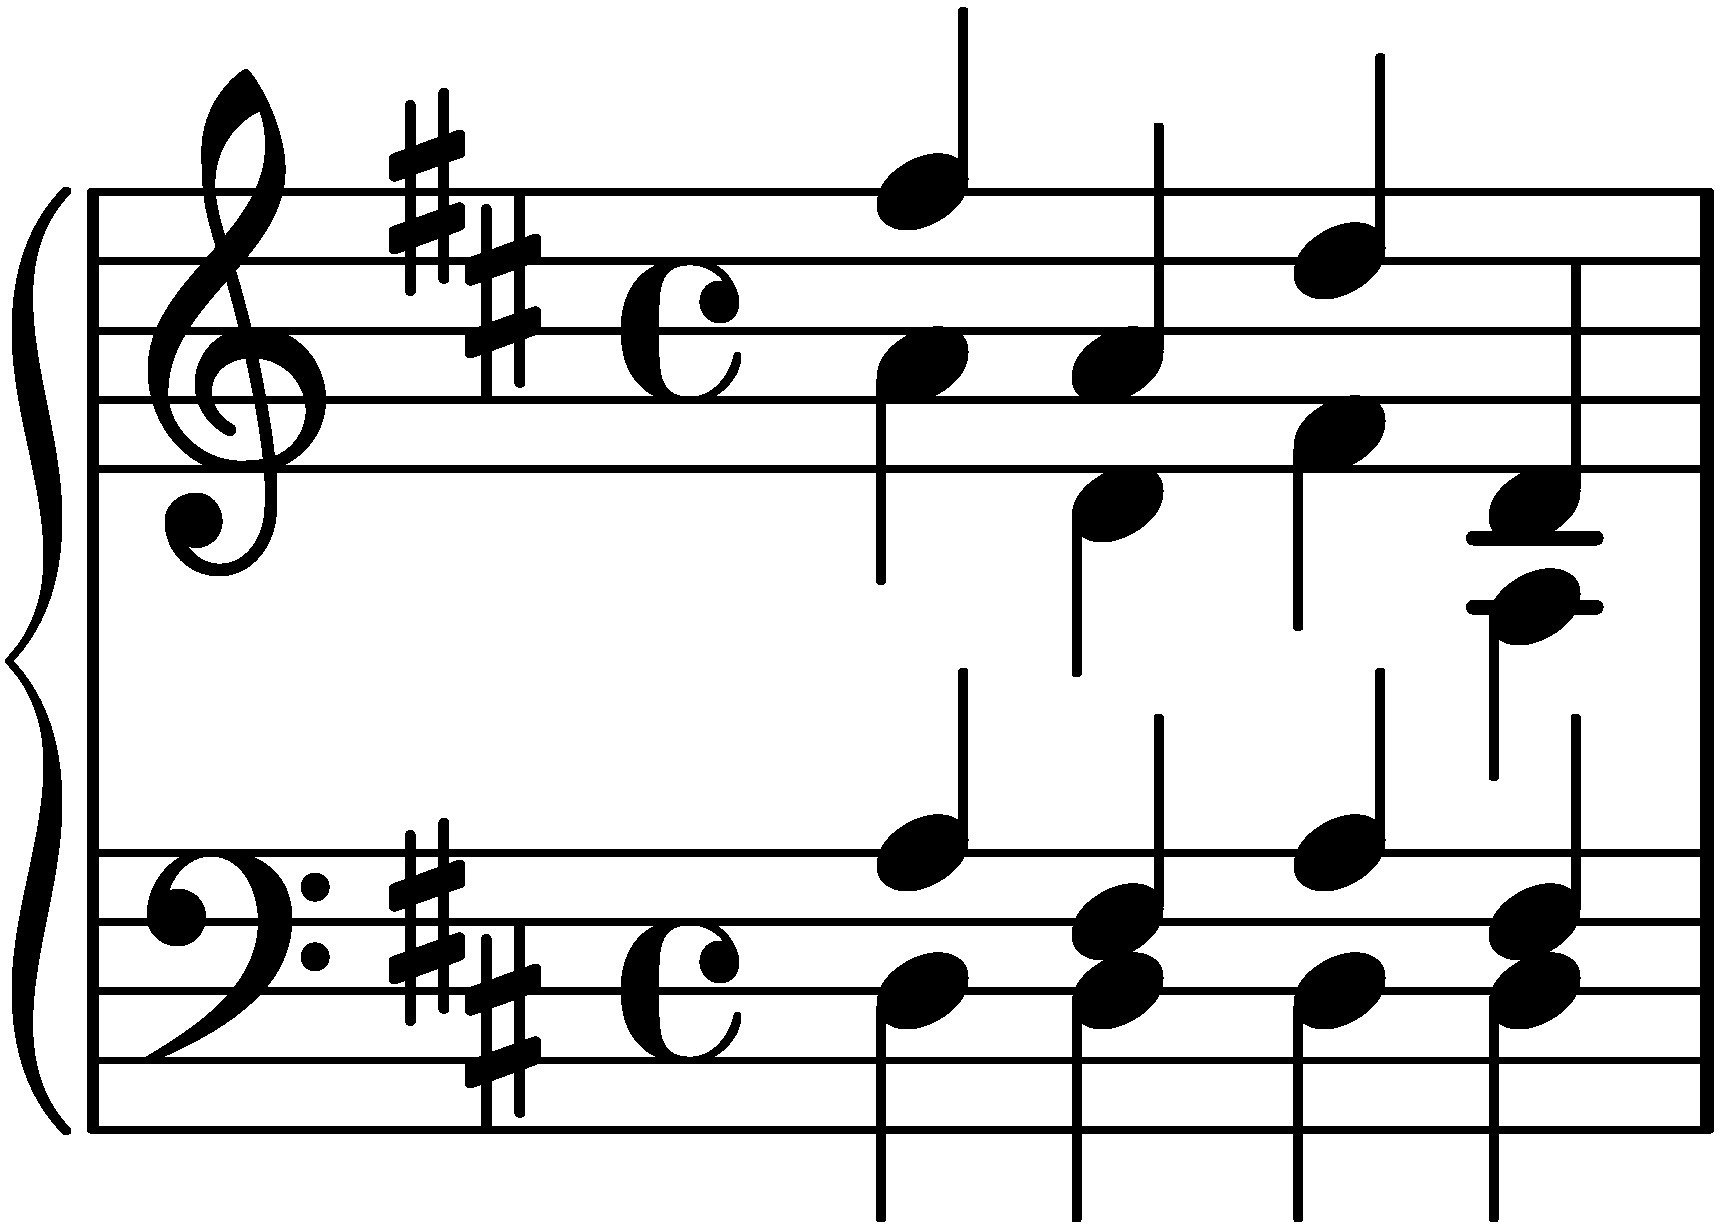

In [6]:
display.Image('img/all_same.jpg', width=400)

In [7]:
def creatChord(nameC, noteF):
    """Create one chord given the name of the chord and the fundamental note"""
    num_funda = int(nameC[:-1])
    if nameC[-1] == 'M':
        val_notes = [num_funda, (num_funda+4)%12, (num_funda+7)%12]
    elif nameC[-1] == 'm':
        val_notes = [num_funda, (num_funda+3)%12, (num_funda+7)%12]
    elif nameC[-1] == 'd':
        val_notes = [num_funda, (num_funda+3)%12, (num_funda+6)%12]
    
    # Tessitura of each voice
    tenorR = list(range(48, 69))
    contR = list(range(52, 77))
    sopR = list(range(60, 86))
    
    # Depending in the bass note this are the options for the others voices
    if noteF%12 == val_notes[0]:
        opc = [[1,1,1], [2,1,0], [0,1,2]]
    elif noteF%12 == val_notes[1]:
        opc = [[1,0,2], [3,0,0], [2,0,1]]
    elif noteF%12 == val_notes[2]:
        opc = [[1,1,1], [2,1,0]]
    
    opc = random.choice(opc)
    chordN = list()
    for num, val in zip(opc, val_notes):
        chordN += [val]*num
    
    random.shuffle(chordN)
    
    chord = [noteF,]
    for nte, voce in zip(chordN, [tenorR, contR, sopR]):
        posible_n = [x for x in voce if x%12 == nte]
        chord.append(random.choice(posible_n))
    
    return chord

After this function, I only need to select a chord for each of the notes in the bass. This process use the midi representation of the notes and making arithmetic operation with them and with a random choice between the possible options. At the end we have a complete chord progression.

In [8]:
def selChord(ton, notesBass):
    """Select the chords from all the posibilities"""
    listaOp = OPTIONS_M if ton[-1] == 'M' else OPTIONS_m
    listaMod = MOD_M if ton[-1] == 'M' else MOD_m
    prog = list()
    
    for note in notesBass:
        name = note%12
        grad = name-int(ton[:-1])
        grad = math.ceil(((grad+12)%12) / 2)
        num = (random.choice(listaOp[grad]) + name +12) % 12
        grad = num-int(ton[:-1])
        grad = math.ceil(((grad+12)%12) / 2)
        name = '{}{}'.format(num, listaMod[grad])
        prog.append([creatChord(name, note), grad])
    return prog

Now, DEAP requires a generator to create the individuals, so I just create a simple generator that yields each chord of the progression.

In [9]:
def newChordProg(ton, notes):
    """Create a new individual given the tonality and the base notes"""
    chords = selChord(ton, notes)
    for c in chords:
        yield c

### Selection

From Wikipedia: _"During each successive generation, a proportion of the existing population is selected to breed a new generation. Individual solutions are selected through a fitness-based process, where fitter solutions (as measured by a fitness function) are typically more likely to be selected."_
So, I created a fitness function based on the classical harmony, it evaluate the progression to find "errors" like a distance between notes greater than an octave, or try to avoid two voices singing the same note:

In [10]:
def check_interval(chord):
    """Return the number of mistakes in the distance between the notes."""
    res = 0
    if chord[2] - chord[1] > 12 or chord[2]-chord[1] < 0:
        res += 15
    if chord[3] - chord[2] > 12 or chord[3]-chord[2] < 0:
        res += 15
        
    if chord[1] == chord[2] or chord[2] == chord[3]:
        res += 1.4
    return res    

Also between two chords, you have to avoid the consecutive fifths and octaves, and a normal person tends to make the intervals in a voice more _"natural"_ making jumps not bigger than a fifth that often.

In [11]:
def check_2_chords(ch1, ch2):
    """Return the number of mistakes in the intervals between 2 chords."""
    res = 0
    
    # Check for 5° and 8°
    ite1 = map(lambda x,y: y-x, ch1[:-1], ch1[1:])
    ite2 = map(lambda x,y: y-x, ch2[:-1], ch2[1:])
    for inter1, inter2 in zip(ite1, ite2):
        if inter1 == 7 and inter2 == 7:
            res += 15
        elif inter1 == 0 and inter2 == 0:
            res += 15
        elif inter1 == 12 and inter2 == 12:
            res += 15
    
    # Check for big intervals, just to make it more "human" 
    for note1, note2 in zip(ch1[1:], ch2[1:]):
        if abs(note1-note2) >= 7: # 7 equals 5° interval
            res += .7
    
    return res

And for the evaluation of an individual I used this generator to access an element and the two neighbors:

In [12]:
def neighborhood(iterable):
    """Generator gives the prev actual and next."""
    iterator = iter(iterable)
    prev = None
    item = next(iterator)  # throws StopIteration if empty.
    for nex in iterator:
        yield (prev,item,nex)
        prev = item
        item = nex
    yield (prev,item,None)

The actual evaluation function:

In [13]:
def evalNumErr(ton, individual):
    """Evaluation function."""
    res = 0
    for prev, item, nex in neighborhood(individual):
        res += check_interval(item[0])
        if prev == None:
            if item[1] != 0:
                res += 6
            continue
        else:
            if prev[1] in [4, 6] and item[1] in [3, 1]:
                res += 20
            res += check_2_chords(prev[0], item[0])
        if nex == None:
            if item[1] in [1, 2, 3, 4, 5, 6]:
                res += 6
    return (res,)
            

### Crossover

In the crossover section I used a simple [One point crossover][1] provided by DEAP in its set of tools.

   [1]: https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)#One-point_crossover

### Mutation

In the mutation section I just create a new chord for each one of the lasts chords that randomly pass a threshold.

In [14]:
def mutChangeNotes(ton, individual, indpb):
    """Mutant function."""
    new_ind = toolbox.clone(individual)
    for x in range(len(individual[0])):
        if random.random() < indpb:
            
            listaOp = OPTIONS_M if ton[-1] == 'M' else OPTIONS_m
            listaMod = MOD_M if ton[-1] == 'M' else MOD_m
            
            note = individual[x][0][0]
            
            name = note%12
            grad = name-int(ton[:-1])
            grad = math.ceil(((grad+12)%12) / 2)
            num = (random.choice(listaOp[grad]) + name +12) % 12
            grad = num-int(ton[:-1])
            grad = math.ceil(((grad+12)%12) / 2)
            name = '{}{}'.format(num, listaMod[grad])
            
            new_ind[x] = [creatChord(name, note), grad]
    
    del new_ind.fitness.values
    return new_ind,

The next function is just to create a lilypond file using the chords in the individual to see a nice sheet.

In [15]:
def transform_lilypond(ton, indiv, make_file=False):
    """Take one list of chords and print the it in lilypond notation."""
    note_map = dict()
    if ton[-1] == 'M':
        note_map = {0: 'c',
                    1: 'cis',
                    2: 'd',
                    3: 'dis',
                    4: 'e',
                    5: 'f',
                    6: 'fis',
                    7: 'g',
                    8: 'gis',
                    9: 'a',
                    10:'ais',
                    11:'b'
                    }
        gra = 'major'
    else:
        note_map = {0: 'c',
                    1: 'des',
                    2: 'd',
                    3: 'ees',
                    4: 'e',
                    5: 'f',
                    6: 'ges',
                    7: 'g',
                    8: 'aes',
                    9: 'a',
                    10:'bes',
                    11:'b'
                    }
        gra = 'minor'
    voces = [[], [], [], []]
    
    for chord in indiv:
        for note, voce in zip(chord, voces):
            
            octave = (note // 12)-4
            name_lily = note_map[note % 12]
            if octave < 0:
                name_lily += ',' * (octave * -1)
            elif octave > 0:
                name_lily += "'" * octave
            voce.append(name_lily)
    
    if make_file:
        with open('lily/'+ton+'.ly', 'w') as f:
            key_map = {'0': 'c',
                    '1': 'des',
                    '2': 'd',
                    '3': 'ees',
                    '4': 'e',
                    '5': 'f',
                    '6': 'ges',
                    '7': 'g',
                    '8': 'aes',
                    '9': 'a',
                    '10':'bes',
                    '11':'b'
                    }
            print(ton)
            f.write(Template(TEMPLATE).substitute(key=key_map[ton[:-1]], grade=gra, notes='{}|\n{}|\n{}|\n{}|\n'.format(*(' '.join(voce) for voce in reversed(voces)))))
    
    print('{}|\n{}|\n{}|\n{}|\n'.format(*(' '.join(voce) for voce in reversed(voces))))

In the main function is where the actual algorithm's running, it's a simple evolutionary algorithm with a hall of fame where the best individuals will be saved. The little while loop is just if you want to run multiple times the algorithm until an individual gets an evaluation lower than, in this case, 15.

In [16]:
def main(ton):
    pop = toolbox.population(n=400)
    hof = tools.HallOfFame(3)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('avg', numpy.mean)
    stats.register('std', numpy.std)
    stats.register('min', numpy.min)
    stats.register('max', numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=70, stats=stats, halloffame=hof, verbose=True)
    while min(log.select('min')) > 15:
        pop = toolbox.population(n=400)
        pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=70, stats=stats, halloffame=hof, verbose=True)
        
    for best in hof:
        print([x[0] for x in best], end='\n============\n')
    transform_lilypond(ton, [x[0] for x in hof[0]], make_file=True)

And at the end set up all the functions and the form of the individual in the toolbox that way DEAP can use them in the algorithm.

The program verbose each of the generations showing the number of individuals evaluated, the average evaluation value, the standard deviation, the minimum and the maximum. At the end it shows the three best individuals in all the evolution process, and it creates a lilypond file with the best of all.

In [17]:
if __name__ == '__main__':
    line = input('n[#b] notas ')
    ton, notes = setTon(line)
    print(ton, notes)
    
    # ========================= GA setup =========================
    creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register('creat_notes', newChordProg, ton, notes)
    toolbox.register('individual', tools.initIterate, creator.Individual,
                     toolbox.creat_notes)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    toolbox.register('evaluate', evalNumErr, ton)
    toolbox.register('mate', tools.cxOnePoint)
    toolbox.register('mutate', mutChangeNotes, ton, indpb=0.4)
    toolbox.register('select', tools.selTournament, tournsize=3)
    # =============================================================
    
    main(ton)

n[#b] notas 2# 50 43 49 50 52 45 49 50 43 45 50
2M [50, 43, 49, 50, 52, 45, 49, 50, 43, 45, 50]
gen	nevals	avg    	std    	min 	max  
0  	400   	192.941	40.4261	74.7	342.5
1  	266   	160.948	32.789 	72.1	271.8
2  	257   	134.057	28.551 	54.1	210.4
3  	240   	113.586	24.9868	59.7	202.1
4  	255   	93.9745	21.3223	40.7	170.7
5  	284   	79.717 	17.2622	33.3	133.8
6  	260   	68.4303	17.4142	14.7	143.6
7  	277   	58.1252	17.5453	12.6	121.1
8  	261   	46.961 	16.5809	10.5	118.1
9  	281   	37.9377	15.1737	10.5	110  
10 	268   	30.1495	14.4993	10.5	95.7 
11 	278   	22.99  	13.0983	7.7 	80   
12 	268   	18.4485	10.7724	7   	65.7 
13 	260   	15.9075	9.36008	7   	64.3 
14 	268   	17.2242	12.5839	7   	86.9 
15 	242   	14.1982	10.0557	7   	77.2 
16 	253   	15.0447	12.3832	7   	77.9 
17 	274   	13.5815	11.4407	6.3 	78.6 
18 	244   	12.6613	11.3568	6.3 	76.5 
19 	272   	12.3715	11.2574	6.3 	84.8 
20 	243   	11.494 	10.8608	6.3 	77.2 
21 	270   	12.2858	11.6018	5.6 	69.1 
22 	248   	10.8537	10.1359	5.6

And just to show the result I made a little script to trim the pdf that lilypond generate.

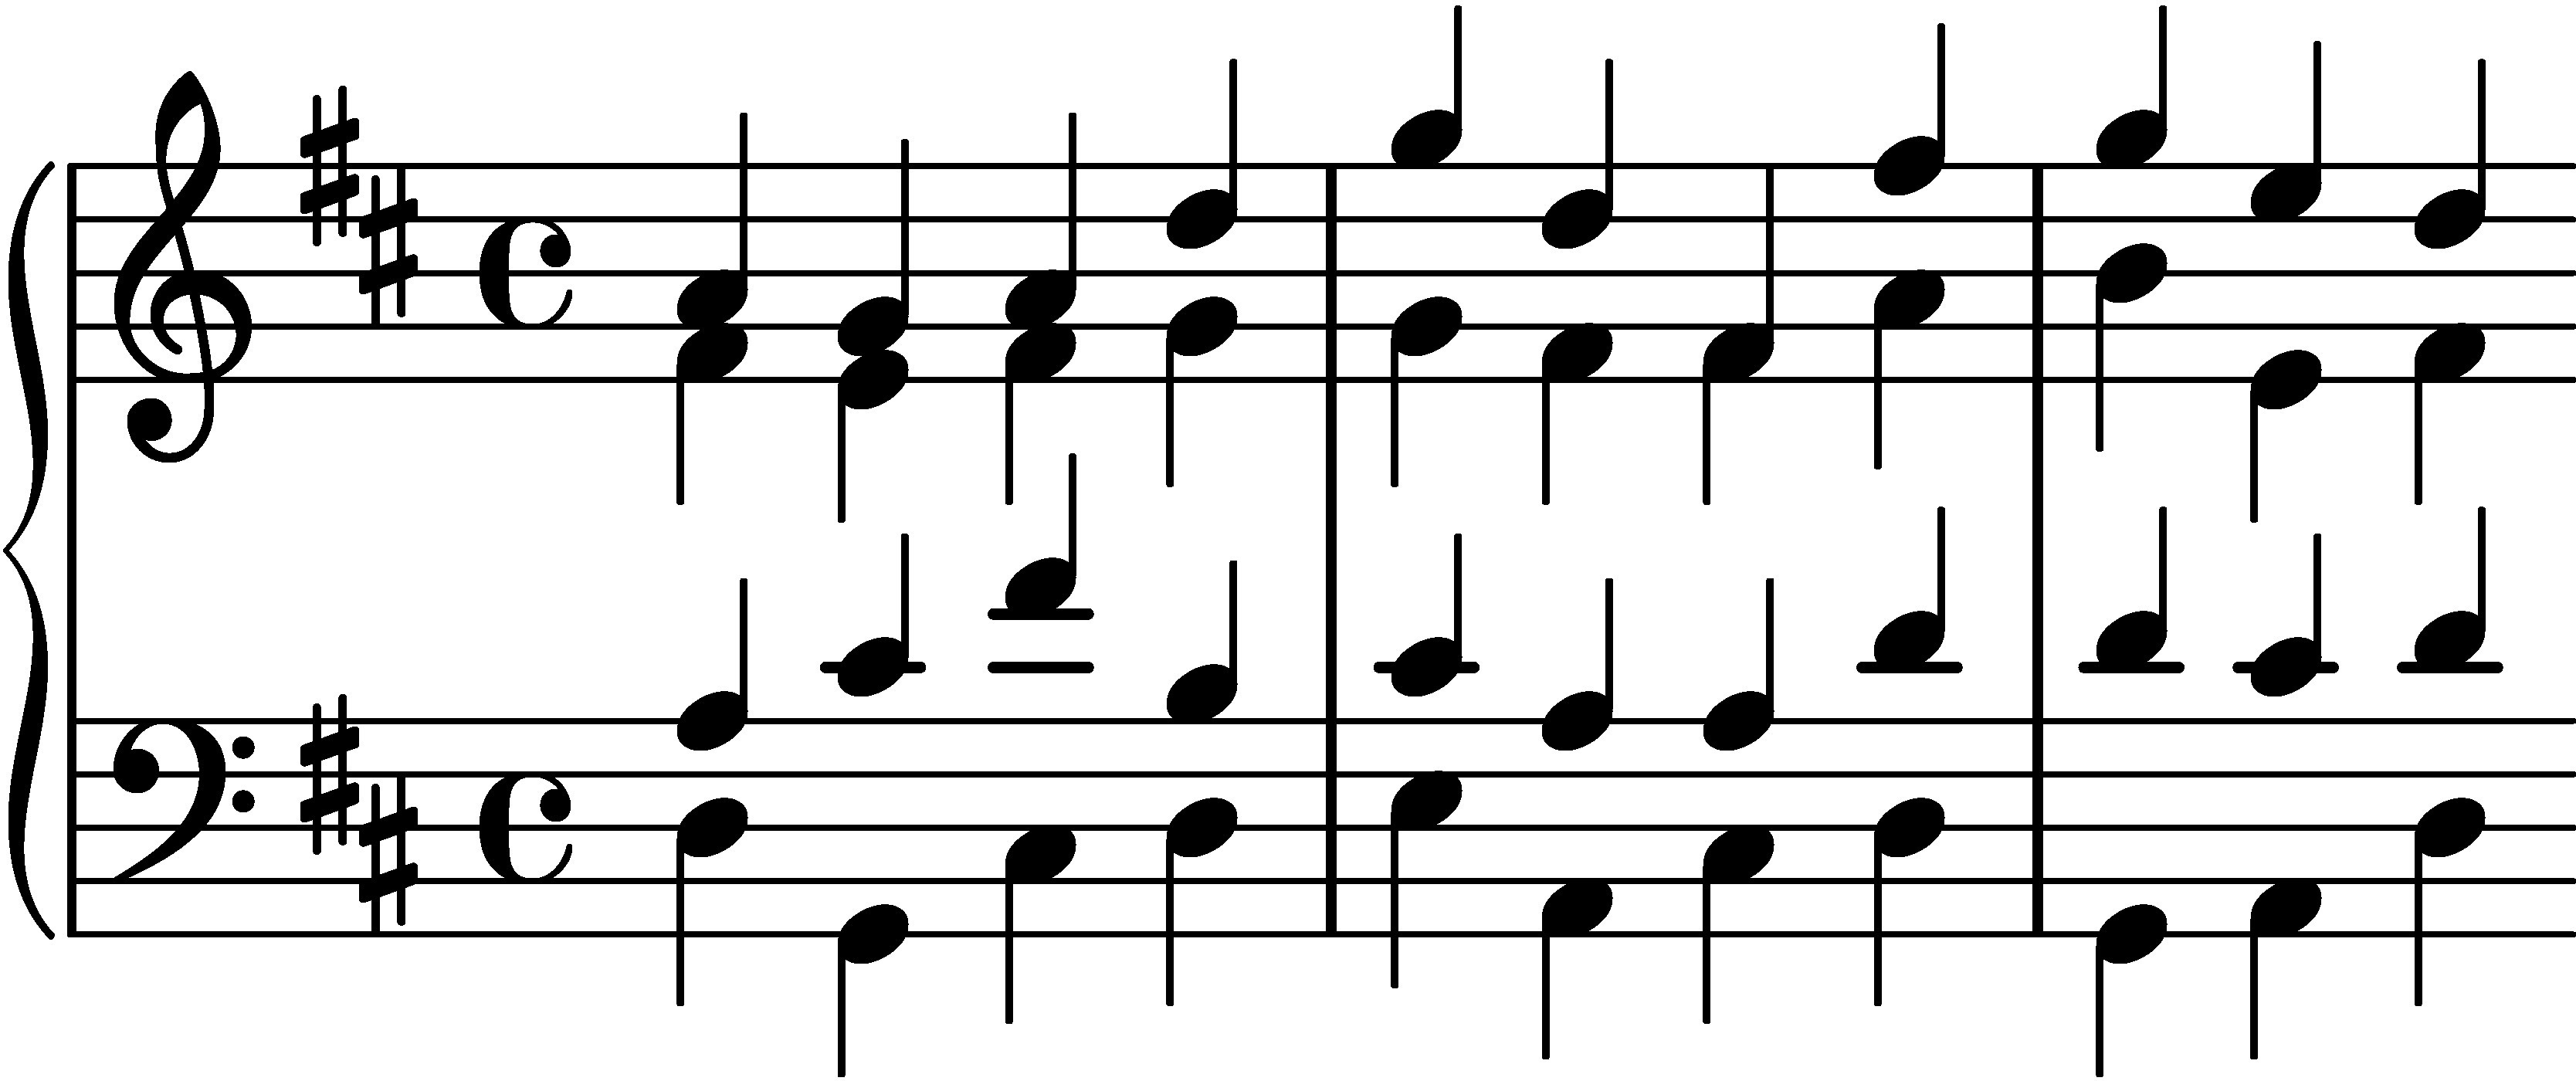

In [18]:
import os

os.system('python auto_trim.py {} {}'.format('lily/'+ton+'.ly', 'temp.jpg'))
display.Image('img/temp.jpg', width=600)

### Conclusion

This little experiment was just to have fun in my first approach to genetic algorithms, I'm pretty sure that there are better ways to create this kind of chord progression, please if you have any comments feel free to write them down.

This notebook and the scripts that I used are available in [my github](http://github.com/schiob/MusGen), you can fork it and play with it, down are some test cases that I used or you can create your own following the same format.

Test cases:
- 2# 54 67 69 61 62
- 1# 43 50 48 47 45 43 55 52 50 48 52 50 50 43 45 47 48 47 48 52 50 38 43
- 2# 50 43 49 50 52 45 49 50 43 45 50
- 2b 46 50 48 51 53 51 48 45 46